In [1]:
import random
import re
import pandas as pd
import json
from tqdm import tqdm
import pprint
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.decomposition import PCA
from umap.umap_ import UMAP
import numpy as np
import os
from transformers import RobertaTokenizer

filename = "pyedur_full.jsonl"

c:\Users\ovane\miniconda3\envs\dl2-code-io\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def print_line(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        for i in range(random.randint(0,1630607)):
            f.readline()
        pprint.pp(f.readline())


def num_rows(file_path):
    count = 0
    with open(file_path, 'r', encoding='utf-8') as f:
        for _ in f:
            count += 1

    print(f'Total number of rows: {count}')
    return count

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
total_datapoints = num_rows('ast-pyedur_full.jsonl')

Total number of rows: 1630607


In [ ]:
print_line(filename)

{"prompt": "You are given a question that requires some input and output variables as follows:\n\nGiven a list of integers, how can we determine the smallest number using different divide-and-conquer strategies, or calculate the sum of elements at positions that are multiples of 3, or find the r-th root of a number with a specified precision?\n\nThe input and output requirements are as follows:\n\nInput:\n  `data` (list): A list of integers. For the 'root' operation, the list should contain exactly three elements: the number `n`, the root `r`, and the precision `p`.\n  `operation` (str): A string indicating the operation to perform. Valid values are 'min', 'minChip', 'sumMultiples', and 'root'.\n\nOutput:\n  `return` (int or float): The result of the specified operation. For 'min', 'minChip', and 'sumMultiples', it returns an integer. For 'root', it returns a float.\n\nGiven the following input:\n\n{'data': [-52, 83, 78, -31, -100, -56, 33, -32, -93, 38], 'operation': 'sumMultiples'}\n

In [ ]:
import json
import tiktoken

def average_prompt_tokens(file_path, model="gpt-3.5-turbo"):
    enc = tiktoken.encoding_for_model(model)
    total_tokens = 0
    total_prompts = 0

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                obj = json.loads(line)
                prompt = obj.get("prompt", "")
                token_count = len(enc.encode(prompt))
                total_tokens += token_count
                total_prompts += 1
            except json.JSONDecodeError:
                continue  # Skip malformed lines

    if total_prompts == 0:
        print("No valid prompts found.")
        return

    average = total_tokens / total_prompts
    print(f"Average number of tokens in 'prompt': {average:.2f}")


In [ ]:
average_prompt_tokens(filename)


Average number of tokens in 'prompt': 809.38


In [2]:
def analyze_code_tokens_codebert(file_path, model_name="microsoft/codebert-base"):
    tokenizer = RobertaTokenizer.from_pretrained(model_name)
    total_tokens = 0
    total_codes = 0
    max_tokens = 0

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                obj = json.loads(line)
                code = obj.get("code", "")
                tokenized = tokenizer.encode(code, add_special_tokens=True)
                token_count = len(tokenized)
                total_tokens += token_count
                total_codes += 1
                max_tokens = max(max_tokens, token_count)
            except json.JSONDecodeError:
                continue  # Skip malformed lines

    if total_codes == 0:
        print("No valid code entries found.")
        return

    average = total_tokens / total_codes
    print(f"Average number of CodeBERT tokens in 'code': {average:.2f}")
    print(f"Maximum number of CodeBERT tokens in 'code': {max_tokens}")

In [4]:
analyze_code_tokens_codebert('/content/drive/MyDrive/DL2/subset.jsonl')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1167 > 512). Running this sequence through the model will result in indexing errors


Average number of CodeBERT tokens in 'code': 898.05
Maximum number of CodeBERT tokens in 'code': 7125


In [ ]:
import json
import ast

# Extract code after the marker
def extract_code(prompt):
    marker = "You can refer to this code to guide your reasoning but not copy spans of code directly."
    if marker in prompt:
        return prompt.split(marker, 1)[-1].strip()
    return ""

# Convert code to AST
def code_to_ast(code):
    try:
        tree = ast.parse(code)
        return ast.dump(tree)
    except SyntaxError as e:
        print(f"SyntaxError in parsing code: {e}")
        return None

def process_jsonl(input_path, output_path, buffer_size=5000):
    buffer = []

    # First, count total lines for tqdm
    with open(input_path, 'r', encoding='utf-8') as f:
        total_lines = sum(1 for _ in f)

    with open(input_path, 'r', encoding='utf-8') as infile, \
         open(output_path, 'w', encoding='utf-8') as outfile:

        for idx, line in enumerate(tqdm(infile, total=total_lines, desc="Processing JSONL")):
            try:
                data = json.loads(line)

                # Phase 1: Extract code
                prompt = data.get("prompt", "")
                code = extract_code(prompt)
                data["code"] = code

                # Phase 2: Convert to AST
                ast_representation = code_to_ast(code)
                if ast_representation is not None:
                    data["ast"] = ast_representation

                buffer.append(json.dumps(data))

                # Write in chunks
                if len(buffer) >= buffer_size:
                    outfile.write("\n".join(buffer) + "\n")
                    buffer.clear()

            except Exception as e:
                print(f"[Line {idx}] Error: {e}")
                continue

        # Write any remaining lines
        if buffer:
            outfile.write("\n".join(buffer) + "\n")


In [ ]:
ast_dataset = "ast-pyedur_full.jsonl"
# process_jsonl(filename,ast_dataset)

In [ ]:
print_line(ast_dataset)
num_rows(ast_dataset)

('{"prompt": "You are given a question that requires some input and output '
 'variables as follows:\\n\\nGiven the dimensions of a 3D volume in pixels, '
 'the A/pixel for the generated map, and the type of model to create (random '
 'or specified), how many Gaussian blobs are used to construct the model, and '
 'what are the dimensions of the resulting model?\\n\\nThe input and output '
 'requirements are as follows:\\n\\nInput:\\n- `dimensions` (list of int): The '
 'dimensions of the volume in pixels [x, y, z].\\n- `apix` (float): The '
 'A/pixel for the generated map.\\n- `model_type` (str): The type of model to '
 "create, either 'r' for random or 's' for specified.\\n- `blobs` (list of "
 'list of float): The parameters for each blob. For random models, this is '
 'generated internally. For specified models, this is provided by the user. '
 'Each blob is a list of 6 floats representing [r, theta, z, dx, dy, '
 'dz].\\n\\nOutput:\\n- `return` (dict): A dictionary containing the '

In [ ]:
def calculate_complexity(ast_str):
    metrics = {
        'functions': r'FunctionDef\(',
        'loops': r'(For\()|(While\()',
        'conditionals': r'If\(',
        'calls': r'Call\(',
        'assignments': r'(Assign\()|(AugAssign\()'
    }
    return sum(len(re.findall(pattern, ast_str)) for pattern in metrics.values())

def process_large_dataset(jsonl_path, target_size=6000):
    # First pass: Calculate complexity distribution
    complexities = []
    with open(jsonl_path) as f:
        for line in tqdm(f, desc="First pass - analyzing complexity"):
            entry = json.loads(line)
            complexities.append(calculate_complexity(entry['ast']))

    # Calculate quantile boundaries
    low_cut, high_cut = np.percentile(complexities, [33, 66])

    # Second pass: Stratified sampling
    samples = {'low': [], 'medium': [], 'high': []}
    sample_size = target_size // 3
    current_counts = {'low': 0, 'medium': 0, 'high': 0}

    with open(jsonl_path) as f:
        for line in tqdm(f, desc="Second pass - sampling"):
            entry = json.loads(line)
            complexity = calculate_complexity(entry['ast'])

            # Determine tier
            if complexity <= low_cut:
                tier = 'low'
            elif complexity <= high_cut:
                tier = 'medium'
            else:
                tier = 'high'

            # Reservoir sampling for each tier
            if current_counts[tier] < sample_size:
                samples[tier].append(entry)
                current_counts[tier] += 1
            else:
                # Random replacement to maintain randomness
                r = np.random.randint(0, current_counts[tier])
                if r < sample_size:
                    samples[tier][r] = entry

    # Combine and shuffle results
    final_sample = samples['low'] + samples['medium'] + samples['high']
    np.random.shuffle(final_sample)
    return final_sample[:target_size]

In [ ]:
# Usage
# filtered_dataset = process_large_dataset('ast-pyedur_full.jsonl', 6000)

In [ ]:
def save_sampled_data(sampled_entries, output_path):
    """Save sampled entries to a JSONL file"""
    with open(output_path, 'w') as f:
        for entry in tqdm(sampled_entries, desc="Saving sampled data"):
            json_line = json.dumps(entry, ensure_ascii=False)
            f.write(json_line + '\n')

save_sampled_data(filtered_dataset, 'subset.jsonl')

Saving sampled data: 100%|██████████| 6000/6000 [00:00<00:00, 6646.77it/s]


In [ ]:
def analyze_complexity_distribution(jsonl_path, num_buckets=20):
    """Analyze complexity distribution using streaming quantile estimation"""
    # First pass: Calculate complexity percentiles
    complexities = []
    batch_size = 10000
    with open(jsonl_path) as f:
        for line in tqdm(f, desc="Estimating distribution"):
            entry = json.loads(line)
            complexities.append(calculate_complexity(entry['ast']))

            # Process in batches to manage memory
            if len(complexities) >= batch_size:
                percentiles = np.percentile(complexities, np.linspace(0, 100, num_buckets+1))
                complexities.clear()  # Reset but keep distribution shape

    # Final percentile calculation
    percentiles = np.unique(np.percentile(complexities, np.linspace(0, 100, num_buckets+1)))
    bucket_counts = {i: 0 for i in range(num_buckets)}

    # Second pass: Count entries in each bucket
    with open(jsonl_path) as f:
        for line in tqdm(f, desc="Counting distribution"):
            entry = json.loads(line)
            c = calculate_complexity(entry['ast'])

            # Find bucket using binary search
            bucket = np.searchsorted(percentiles, c, side='right') - 1
            bucket = min(max(bucket, 0), num_buckets-1)
            bucket_counts[bucket] += 1

    return {
        'percentiles': percentiles.tolist(),
        'counts': bucket_counts,
        'statistics': {
            'mean': np.mean(list(bucket_counts.values())),
            'std_dev': np.std(list(bucket_counts.values())),
            'total': sum(bucket_counts.values())
        }
    }

In [ ]:
distribution = analyze_complexity_distribution('ast-pyedur_full.jsonl')


Estimating distribution: 1630607it [13:31, 2009.60it/s]
Counting distribution: 1630607it [13:37, 1994.58it/s]


In [ ]:
print(distribution)

{'percentiles': [2.0, 9.0, 12.0, 15.0, 17.200000000000003, 20.0, 22.0, 25.0, 28.0, 31.0, 34.0, 38.0, 41.0, 45.0, 49.19999999999999, 57.0, 66.80000000000001, 78.20000000000005, 99.0, 128.0, 247.0], 'counts': {0: 56396, 1: 65528, 2: 80327, 3: 95579, 4: 66180, 5: 68378, 6: 101404, 7: 96272, 8: 88139, 9: 80646, 10: 98750, 11: 64546, 12: 73887, 13: 79093, 14: 92837, 15: 100201, 16: 88363, 17: 95958, 18: 70391, 19: 67732}, 'statistics': {'mean': np.float64(81530.35), 'std_dev': np.float64(13869.168523292952), 'total': 1630607}}


In [ ]:
pprint.pp(distribution)

{'percentiles': [2.0,
                 9.0,
                 12.0,
                 15.0,
                 17.200000000000003,
                 20.0,
                 22.0,
                 25.0,
                 28.0,
                 31.0,
                 34.0,
                 38.0,
                 41.0,
                 45.0,
                 49.19999999999999,
                 57.0,
                 66.80000000000001,
                 78.20000000000005,
                 99.0,
                 128.0,
                 247.0],
 'counts': {0: 56396,
            1: 65528,
            2: 80327,
            3: 95579,
            4: 66180,
            5: 68378,
            6: 101404,
            7: 96272,
            8: 88139,
            9: 80646,
            10: 98750,
            11: 64546,
            12: 73887,
            13: 79093,
            14: 92837,
            15: 100201,
            16: 88363,
            17: 95958,
            18: 70391,
            19: 67732},
 'statisti

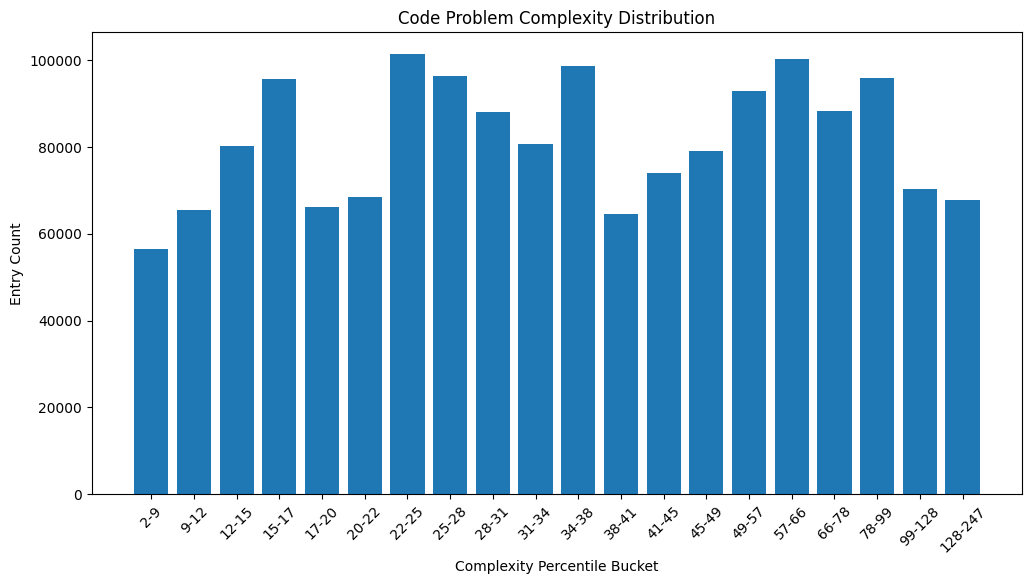

In [ ]:

def plot_complexity_distribution(distribution):
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(distribution['counts'])), distribution['counts'].values())
    plt.xlabel('Complexity Percentile Bucket')
    plt.ylabel('Entry Count')
    plt.title('Code Problem Complexity Distribution')
    plt.xticks(ticks=range(len(distribution['percentiles'])-1),
               labels=[f"{int(distribution['percentiles'][i])}-{int(distribution['percentiles'][i+1])}"
                       for i in range(len(distribution['percentiles'])-1)],
               rotation=45)
    plt.show()

plot_complexity_distribution(distribution)

In [3]:
from transformers import AutoTokenizer, AutoModel
import torch
import json
import numpy as np
import os
from tqdm import tqdm

# 1. Embedding Generation with CodeBERT
def generate_code_embeddings(jsonl_path, embedding_path='embeddings.npy', batch_size=64, max_length=512, chunk_strategy="mean"):
    if os.path.exists(embedding_path):
        print(f"Loading existing embeddings from {embedding_path}")
        return np.load(embedding_path)

    # Add length tracking
    length_stats = {
        'total': 0,
        'chunked': 0,
        'max_length': 0
    }

    tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
    model = AutoModel.from_pretrained("microsoft/codebert-base").cuda()
    embeddings = []

    def num_rows(filepath):
        with open(filepath) as f:
            return sum(1 for _ in f)

    total = num_rows(jsonl_path)
    
    def process_code_chunk(batch):
        inputs = tokenizer(
            batch, return_tensors="pt", padding=True,
            truncation=True, max_length=max_length
        ).to('cuda')
        
        with torch.no_grad():
            outputs = model(**inputs)
        
        return torch.mean(outputs.last_hidden_state, dim=1).cpu()

    with open(jsonl_path) as f:
        for line in tqdm(f, desc="Generating embeddings", total=total):
            entry = json.loads(line)
            code = entry['code']

            # Track original length
            tokens = tokenizer.tokenize(code)
            length_stats['total'] += 1
            length_stats['max_length'] = max(length_stats['max_length'], len(tokens))

            if len(tokens) <= max_length:
                # Code fits within limit - process normally
                chunk_embeddings = process_code_chunk([code])
                embeddings.append(chunk_embeddings[0].numpy())
            else:
                # Code exceeds limit - use chunking
                length_stats['chunked'] += 1
                
                # Split into overlapping chunks with stride
                stride = max_length // 2
                chunk_inputs = []
                
                for i in range(0, len(tokens), stride):
                    chunk_tokens = tokens[i:i+max_length]
                    if len(chunk_tokens) < max_length // 4:  # Skip very small final chunks
                        continue
                    chunk_text = tokenizer.convert_tokens_to_string(chunk_tokens)
                    chunk_inputs.append(chunk_text)
                
                if not chunk_inputs:  # Ensure we have at least one chunk
                    chunk_inputs = [tokenizer.convert_tokens_to_string(tokens[:max_length])]
                
                # Process each chunk in batches
                all_chunk_embeddings = []
                for i in range(0, len(chunk_inputs), batch_size):
                    batch_chunks = chunk_inputs[i:i+batch_size]
                    batch_embs = process_code_chunk(batch_chunks)
                    all_chunk_embeddings.extend([emb for emb in batch_embs])
                
                # Aggregate the chunk embeddings
                all_chunk_embeddings = torch.stack(all_chunk_embeddings)
                if chunk_strategy == "mean":
                    final_embedding = torch.mean(all_chunk_embeddings, dim=0).numpy()
                elif chunk_strategy == "max":
                    final_embedding = torch.max(all_chunk_embeddings, dim=0)[0].numpy()
                else:  # Default to mean
                    final_embedding = torch.mean(all_chunk_embeddings, dim=0).numpy()
                
                embeddings.append(final_embedding)

    # Print chunking stats
    print("Chunking Report:\n",
          f"- Total samples: {length_stats['total']}\n",
          f"- Chunked samples: {length_stats['chunked']} ",
          f"({length_stats['chunked']/length_stats['total']:.1%})\n",
          f"- Max token length: {length_stats['max_length']}")

    embeddings = np.array(embeddings)
    np.save(embedding_path, embeddings)
    print(f"Saved embeddings to {embedding_path}")
    return embeddings

# 2. Dimensionality Reduction
def reduce_dimensions(embeddings, n_components=50):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(embeddings)

# 3. Clustering
def cluster_embeddings(reduced_embeddings, n_clusters=2):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    return kmeans.fit_predict(reduced_embeddings)

# 4. Visualization and Analysis
def analyze_clusters(reduced_embeddings, cluster_labels):
    # UMAP Visualization
    umap_embeddings = UMAP().fit_transform(reduced_embeddings)

    plt.figure(figsize=(12, 8))
    plt.scatter(umap_embeddings[:,0], umap_embeddings[:,1],
                c=cluster_labels, cmap='Spectral', alpha=0.6)
    plt.colorbar()
    plt.title("Code Embedding Clusters")
    plt.show()

# 5. Academic Cluster Interpretation Methods
def interpret_clusters(jsonl_path, cluster_labels, n_samples=5):
    # Load data with clusters
    data = []
    with open(jsonl_path) as f:
        for i, line in enumerate(tqdm(f, desc="Loading data")):
            entry = json.loads(line)
            entry['cluster'] = cluster_labels[i]
            data.append(entry)

    df = pd.DataFrame(data)

    # Academic Analysis Techniques:
    for cluster_id in df['cluster'].unique():
        cluster_df = df[df['cluster'] == cluster_id]
        cluster_size = len(cluster_df)

        print(f"\nCluster {cluster_id} (Size: {cluster_size}) Characteristics:")

        # Handle small clusters
        sample_size = min(n_samples, cluster_size)
        replace = cluster_size < n_samples

        samples = cluster_df.sample(n=sample_size, replace=replace)['code']

        # b. Keyword Frequency Analysis
        from collections import Counter
        keywords = Counter()
        for code in samples:
            keywords.update(code.split())

        print("Top Keywords:", keywords.most_common(5))

        # c. Code Structure Analysis
        print("Sample Code Snippets:")
        for code in samples:
            print("-", code[:100] + "...")

# Full Pipeline
def analyze_code_dataset(jsonl_path,embedding_path):
    # 1. Generate embeddings
    embeddings = generate_code_embeddings(jsonl_path, embedding_path)

    # 2. Reduce dimensionality
    reduced_emb = reduce_dimensions(embeddings)

    # 3. Cluster data
    clusters = cluster_embeddings(reduced_emb)

    # 4. Visualize
    analyze_clusters(reduced_emb, clusters)

    # 5. Interpret clusters
    interpret_clusters(jsonl_path, clusters)

# Usage
# analyze_code_dataset(jsonl_path ='/content/drive/MyDrive/DL2/subset.jsonl', embedding_path='subset_embeddings.npy')

In [4]:
generate_code_embeddings(jsonl_path ='ast-pyedur_full.jsonl', embedding_path='all_embeddings.npy')

Generating embeddings: 100%|██████████| 1630607/1630607 [21:20:00<00:00, 21.23it/s]   


Chunking Report:
 - Total samples: 1630607
 - Chunked samples: 1020478  (62.6%)
 - Max token length: 12062
Saved embeddings to all_embeddings.npy


array([[-0.24000329,  0.19659245,  0.2680612 , ..., -0.35292736,
        -0.42640188,  0.5115442 ],
       [-0.27821928,  0.0817337 ,  0.22677092, ..., -0.45863843,
        -0.48269376,  0.5280295 ],
       [-0.40960354,  0.25005287,  0.275365  , ..., -0.63491213,
        -0.42733008,  0.6128671 ],
       ...,
       [-0.22062415,  0.13766925,  0.1726389 , ..., -0.31721878,
        -0.5208145 ,  0.47550854],
       [-0.3839621 ,  0.25056478,  0.25815025, ..., -0.71273196,
        -0.5145349 ,  0.5583717 ],
       [-0.3481186 ,  0.0792072 ,  0.23760718, ..., -0.5916227 ,
        -0.462018  ,  0.58550763]], shape=(1630607, 768), dtype=float32)